In [1]:
# import numpy and exp mat
import numpy as np
from math import exp, sqrt
# import njit
from numba import njit
from numba.experimental import jitclass

# import timeit
import timeit
# import time
import time

from numba import int32, float64, types

# import random
import random

import matplotlib.pyplot as plt

%matplotlib widget


In [2]:
# the class QuantumSystem have the following attributes:
# - N: number of particles
# - D: number of dimensions
# - params: variational parameters (array)

# and the following methods:
# - __init__: initialize the system
# - set_params: set the variational parameters
# - wavefunction: compute the wavefunction
# - local_energy: compute the local energy

spec = [
    ('N', int32),
    ('D', int32),
    ('params', float64[:]),  # assuming params is a 1D array of floats
]

@jitclass(spec)
class QuantumSystem:
    def __init__(self, N, D, params=np.array([0.])):
        self.N = N
        self.D = D
        self.params = params

    def set_params(self, params):
        # set the variational parameters
        self.params = params

    def wavefunction(self, X):
        # compute the wavefunction
        return exp(-self.params[0]*np.sum(X**2))
    
    def local_energy(self, X):
        # compute the local energy
        return self.N*self.D*self.params[0] + (0.5 - 2*self.params[0]**2)*np.sum(X**2)
    

In [3]:
# the class MetropolisWalker have the following attributes:
# - system: the quantum system
# - X: the initial position (if None, gauss is used)
# - delta: the step size
# - subgroup_size: subgroup of particle to move

# and the following methods:
# - __init__: initialize the walker
# - step: make a step
# - propose: propose a move
# - test: test the move
# - get_chain: get the chain of positions

spec = [
    ('system', QuantumSystem.class_type.instance_type),
    ('X', float64[:,:]),
    ('delta', float64),
    ('subgroup_size', int32),
]

@jitclass(spec)
class MetropolisWalker:
    def __init__(self, system, X=None, delta=0.1, subgroup_size=1):
        self.system = system
        self.delta = delta
        self.subgroup_size = subgroup_size
        if X is None:
            self.X = np.random.randn(self.system.N, self.system.D)
        else:
            self.X = X

    def step(self):
        # make a step
        X_new = self.propose()  
        if self.test(X_new):
            self.X = X_new

    def propose(self):
        # propose a move
        subgroup_indx = np.random.randint(0,self.system.N,self.subgroup_size)
        dX = np.zeros((self.system.N, self.system.D)) 
        dX[subgroup_indx] = (np.random.random((self.subgroup_size,self.system.D))-0.5)*self.delta
        return self.X + dX

    def test(self, X_new):
        # test the move
        likelihood = self.system.wavefunction(X_new)**2/self.system.wavefunction(self.X)**2
        return np.random.random() < likelihood

    def get_chain(self, n_steps):
        # get a chain
        chain = np.zeros((n_steps, self.system.N, self.system.D))
        for i in range(n_steps):
            self.step()
            chain[i] = self.X
        return chain

In [4]:
# the class Analizer have the following attributes:
# - system: the quantum system
# - chain: the chain of positions

# and the following methods:
# - __init__: initialize the analizer
# - get_local_energies: get the local energies
# - get_acceptance_rate: get the acceptance rate
# - block_transform: block transform the energies
# - get_block_std: get the block standard deviation

@njit
def get_acceptance_rate(local_energies):
    # get the local energies, make np.diff and count how many zeros
    return np.count_nonzero(np.diff(local_energies))/len(local_energies)

@njit
def get_local_energies(system, chain):
        # get the local energies
        return np.array([system.local_energy(X) for X in chain])

@njit
def block_transform(energies):
    energies_prime = np.zeros(len(energies)//2)
    for i in range(len(energies)//2):
        energies_prime[i] = 0.5*(energies[2*i] + energies[2*i+1])
    return energies_prime

@njit
def get_block_std(energies):
    energies_prime = energies
    block_std = np.zeros(int(np.log2(len(energies_prime))))
    for i in range(len(block_std)-1):
        energies_prime = block_transform(energies_prime)
        block_std[i] = np.std(energies_prime)/sqrt(len(energies_prime) - 1)
    return block_std




class Analizer:
    def __init__(self, system, chain, block_quantiles=0.8):
        self.system = system
        self.chain = chain
        self.block_quantiles = block_quantiles

        self.local_energies = get_local_energies(self.system, self.chain)
        self.block_std = None

    def get_local_energies(self):
        return self.local_energies

    def get_acceptance_rate(self):
        return get_acceptance_rate(self.local_energies)
    
    def get_block_std(self):
        self.block_std = get_block_std(self.local_energies)
        return self.block_std
    
    def get_mean_energy(self):
        return np.mean(self.local_energies)
    
    def get_std_energy(self):
        self.get_block_std()
        return np.sort(self.block_std)[int(self.block_quantiles*len(self.block_std))]

In [5]:
# the VMC class have the following attributes:
# - system: the quantum system
# - walker: the metropolis walker
# - warmup_steps: number of warmup steps
# - run_steps: number of steps
# - params: the variational parameters
# - plot: verbosity, if True print the acceptance rate and plot
# - warmup_chain: warmup chain
# - run_chain: integral chain
# - plot_dir: directory to save the plot

# and the following methods:
# - __init__: initialize the VMC
# - warmup: warmup the VMC
# - run: integrate the VMC
# - get_energy: get the energy
# - get_energy_std: get the energy standard deviation using blocking


class VMC:
    def __init__(self, system, walker, 
                 params=np.array([0.]),
                 warmup_steps=1000, run_steps=10000, 
                 block_quantiles=0.8,
                 plot=False, plot_dir=None):
        self.system = system
        self.walker = walker

        self.params = params

        self.warmup_steps = warmup_steps
        self.run_steps = run_steps

        self.block_quantiles = block_quantiles

        self.plot = plot
        self.save_plot = plot_dir

        self.warmup_chain = None
        self.run_chain = None
        self.run_analizer = None

        self.system.set_params(self.params)

    def set_params(self, params):   
        # set the variational parameters
        self.params = params
        self.system.set_params(self.params)

    def warmup(self):
        # warmup the VMC
        self.warmup_chain = self.walker.get_chain(self.warmup_steps)

        if self.plot:
            analizer = Analizer(self.system, self.warmup_chain)
            print('Acceptance rate:', analizer.get_acceptance_rate())
            plt.figure()
            plt.plot(analizer.get_local_energies())
            plt.xlabel('steps')
            plt.ylabel('loc energy')
            name = 'Warmup, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.show()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')

    def run(self):
        # integrate the VMC
        self.run_chain = self.walker.get_chain(self.run_steps)
        self.run_analizer = Analizer(self.system, self.run_chain, self.block_quantiles)

        if self.plot:
            print('Acceptance rate:', self.run_analizer.get_acceptance_rate())
            plt.figure()
            plt.plot(self.run_analizer.get_local_energies())
            plt.xlabel('steps')
            plt.ylabel('loc energy')
            name = 'Run, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.show()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')
            plt.figure()
            block_std = self.run_analizer.get_block_std()
            energy_std = np.sort(block_std)[int(len(block_std)*0.8)]
            plt.plot(self.run_analizer.get_block_std(), 'o')
            plt.xlabel('blocking')
            plt.ylabel('loc energy std')
            plt.axhline(y=energy_std, color='r', linestyle='--')
            name = 'Blocking, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.show()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')

    def get_energy(self):
        # get the energy
        return self.run_analizer.get_mean_energy()

    def get_energy_std(self):
        return self.run_analizer.get_std_energy()

In [6]:
# test the classes
N = 10
D = 3

delta = 1.1
subgroup_size = 10

params = np.array([0.9])

system = QuantumSystem(N, D, params)
walker = MetropolisWalker(system, delta=delta)

In [7]:
# get the time for doing 

0.627


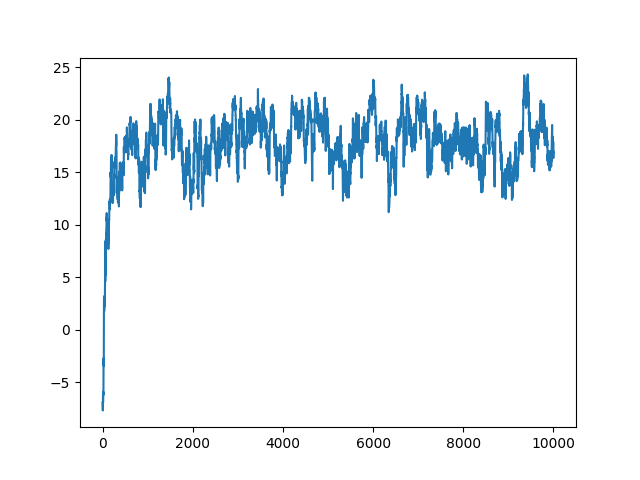

In [8]:
# get a warup_chain for 10000 and analyze it
warmup_chain = walker.get_chain(10000)
analizer = Analizer(system, warmup_chain)
print(analizer.get_acceptance_rate())
# plot the local energies
plt.figure()
plt.plot(analizer.get_local_energies())

In [9]:
# measure the time needed to get energies, get_block_std and get_acceptance_rate
warmup_chain = walker.get_chain(100000)
analizer = Analizer(system, warmup_chain)
start = time.time()
acc = analizer.get_acceptance_rate()
block_std = analizer.get_block_std()
print(time.time()-start)

0.8102090358734131


In [10]:
analizer.get_std_energy()

0.11262698921640904

0.620067


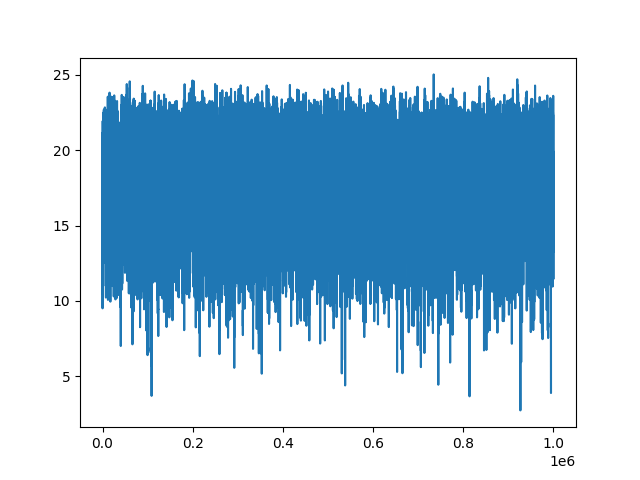

In [11]:
# get a integral_chain for 10000 and analyze it
integral_chain = walker.get_chain(1000000)

analizer = Analizer(system, integral_chain)
print(analizer.get_acceptance_rate())
# plot the local energies
plt.figure()
plt.plot(analizer.get_local_energies())

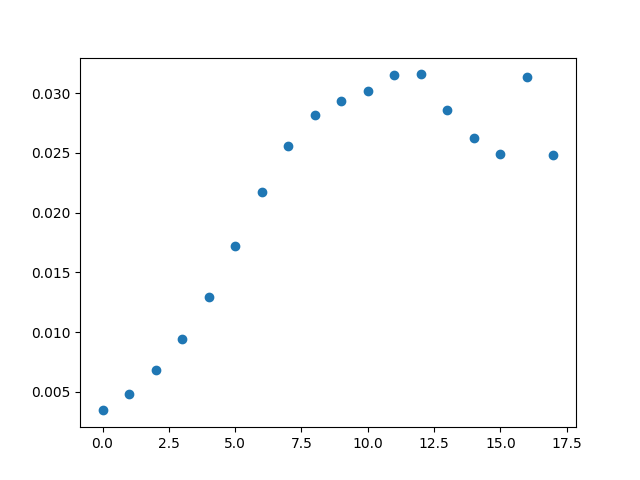

In [12]:
# get block_std
block_std = analizer.get_block_std()
plt.figure()
plt.plot(block_std[:-1], 'o')

In [13]:
# try the VMC with the same parameters as before but redo, verbose=True
params = np.array([0.55])
system = QuantumSystem(N, D, params)
walker = MetropolisWalker(system, delta=delta)
vmc = VMC(system, walker, params=params, plot=True,
          warmup_steps=10000, run_steps=5000000)

Acceptance rate: 0.7011


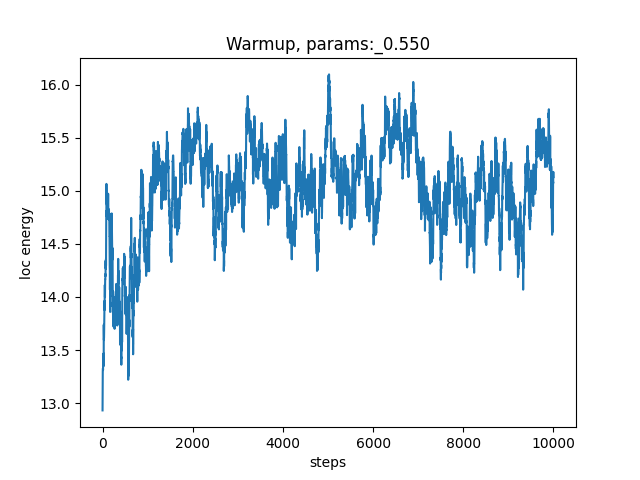

Acceptance rate: 0.696891


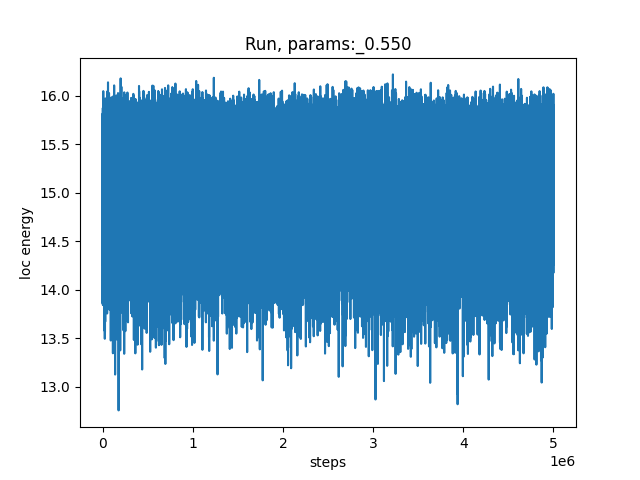

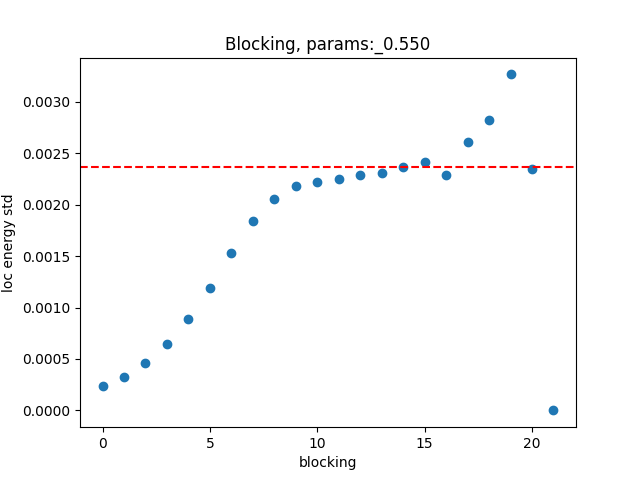

In [14]:
vmc.warmup()
vmc.run()

In [15]:
# print the energy and the energy std
print(vmc.get_energy())
print(vmc.get_energy_std())

15.065926909250454
0.0023700362459550097


Acceptance rate: 0.677


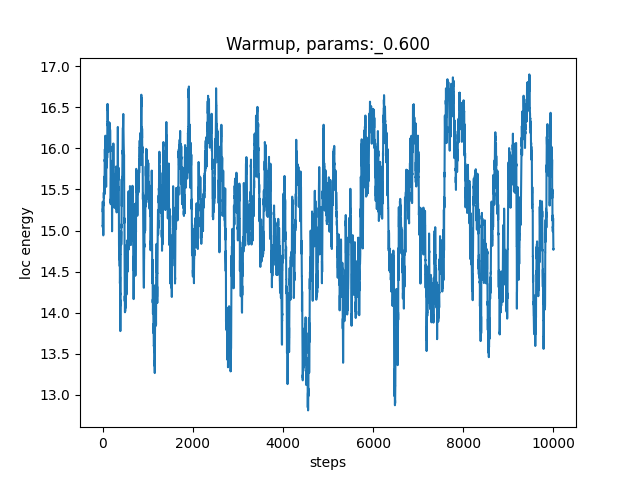

Acceptance rate: 0.6841282


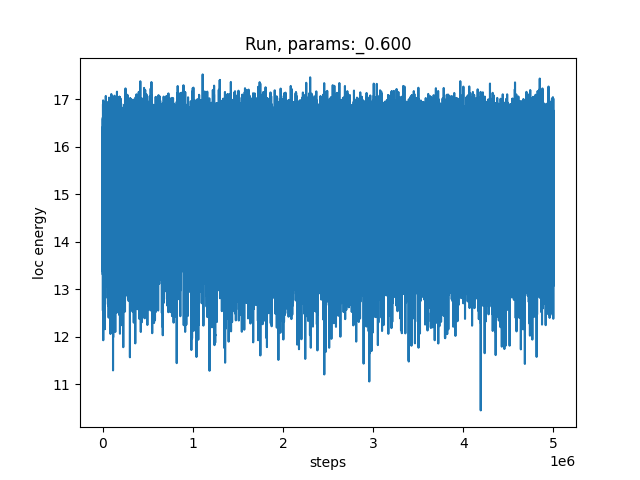

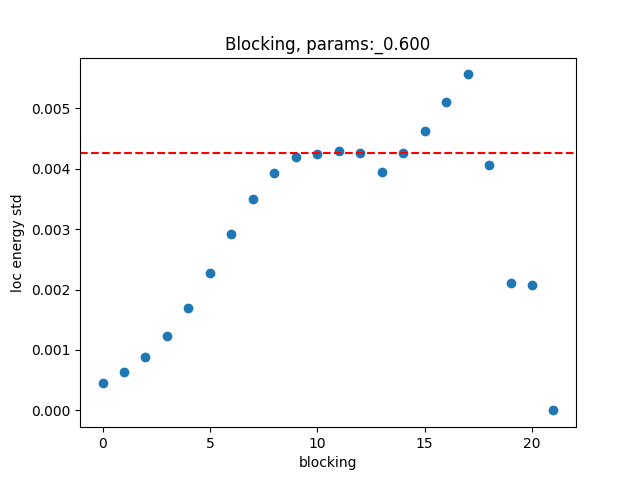

In [16]:
# try with params = 0.6
params = np.array([0.6])
vmc.set_params(params)
vmc.warmup()
vmc.run()

In [17]:
print(vmc.get_energy())
print(vmc.get_energy_std())

15.244904231987908
0.004259967366060915


In [21]:
# make a gridsearch for params = 0.2-1.0 with 0.1 step and plot the energy and the energy std
# warmup step 1000 and run step 10000

params = np.arange(0.2, 1.1, 0.1)
energies = np.zeros(len(params))
energies_std = np.zeros(len(params))

plot_dir = '../test/'

system = QuantumSystem(N, D)
walker = MetropolisWalker(system, delta=delta)
vmc = VMC(system, walker,
          warmup_steps=10000, run_steps=100000, 
          plot=False, plot_dir=plot_dir, 
          block_quantiles=0.8)


start = time.time()
for i, param in enumerate(params):
    # print the param to keep track of the progress
    # print(param)
    vmc.set_params(np.array([param]))
    vmc.warmup()
    vmc.run()
    energies[i] = vmc.get_energy()
    energies_std[i] = vmc.get_energy_std()
stop = time.time()

print(stop-start)


1.377746343612671


<ErrorbarContainer object of 3 artists>

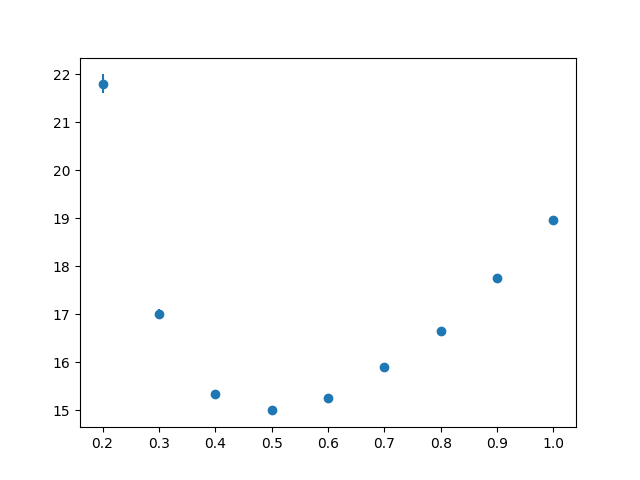

In [19]:
# errorbar plot
plt.figure()
plt.errorbar(params, energies, yerr=energies_std, fmt='o')